In [1]:
import numpy as np
import pandas as pd
import glob

# 1. Creation of the ensemble training set

In [2]:
# load the leak that will be used to run the ensemble
submission = pd.read_feather('leak012345_001.feather')

In [3]:
# initiate the load of the predictions of level 1
sub = pd.read_csv('../sample_submission.csv')
del sub['meter_reading']

In [4]:
# list of predictions of level 1 used as features in ensembling model:

sublist = [
'submission_multimeter003.csv.gz',          #level1--submission_multimeter003--lightgbm.ipynb
'submission_multimeter004_nobuild.csv.gz',  #level1--submission_multimeter004_nobuild--lightgbm.ipynb
'submission_withoutleak001.csv.gz',         #level1--submission_withoutleak001--lightgbm.ipynb
'submission_whatsyourcv3_0052_trncl.csv.gz',#level1--submission_whatsyourcv3_0052_trncl--lightgbm.ipynb

'submission_nn007lofo.csv.gz',  #level1--submission_nn007lofo--CNN.ipynb
'submission_nn001.csv',         #level1--submission_nn001--DenseNN.ipynb
     
'submission_catboost002.csv',   #level1--catboost002--Catboost.ipynb
      
'fe2_lgbm.csv',               #downloaded from https://www.kaggle.com/ragnar123/another-1-08-lb-no-leak (1st commit)
'histgradboost113.csv',       #downloaded from https://www.kaggle.com/tunguz/ashrae-histgradientboosting (last commit)

          ]

In the list above, fe2_lgbm.csv and histgradboost113.csv have been downloaded from https://www.kaggle.com/ragnar123/another-1-08-lb-no-leak (commit #1) and https://www.kaggle.com/tunguz/ashrae-histgradientboosting respectively.

In [5]:

# function to aggregate the predictions in one unique pandas
def join_sub(pathlist, sub):
    name_list = []
    for path in pathlist:
        name_tmp = path.split('/')[-1].split('.')[0]
        print(name_tmp)
        sub_tmp = pd.read_csv(path).sort_values(by='row_id')
        sub_tmp.rename(columns={'meter_reading': name_tmp}, inplace=True)
        
        sub_tmp[name_tmp] = sub_tmp[name_tmp].apply(lambda x: 0 if x < 0 else x)
        sub_tmp[name_tmp] = np.log1p(sub_tmp[name_tmp].values)
                                                                  
        sub = pd.concat([sub, sub_tmp[name_tmp]], axis=1)
        name_list.append(name_tmp)
    return sub, name_list

In [6]:
subm, name_list = join_sub(sublist, sub)

submission_multimeter003
submission_multimeter004_nobuild
submission_withoutleak001
submission_whatsyourcv3_0052_trncl
submission_nn007lofo
submission_nn001
another_108_catboost002
fe2_lgbm
histgradboost113


In [7]:
subm.head()

,row_id,submission_multimeter003,submission_multimeter004_nobuild,submission_withoutleak001,submission_whatsyourcv3_0052_trncl,submission_nn007lofo,submission_nn001,another_108_catboost002,fe2_lgbm,histgradboost113
0,0,5.137161,5.089781,5.029254,5.132836,5.235737,5.288472,5.257317,5.035160,5.200388
1,1,4.188979,4.347783,4.294870,4.211026,4.328701,4.581579,4.289154,4.466447,4.432485
2,2,2.020209,2.860485,2.371897,2.175479,1.903644,2.379749,2.105403,2.397863,2.427290
3,3,5.323947,5.389596,5.516343,5.686560,5.823222,5.751170,5.775866,5.485559,5.559772
4,4,7.141346,6.877661,7.246858,7.121456,7.415066,7.167617,7.111460,7.024336,7.006811


In [8]:
test = pd.read_feather('test_simple_cleanup.feather')
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,na_year_built,...,had_heat,had_windchill,had_feellike,had_air_temperature_mean_lag3,had_dew_temperature_mean_lag3,had_heat_mean_lag3,had_windchill_mean_lag3,had_feellike_mean_lag3,tm_day_of_week,tm_hour_of_day
0,0,0,0,8784,0,0,7432,2008,-1,0,...,1,1,1,1,1,1,1,1,2,0
1,1,1,0,8784,0,0,2720,2004,-1,0,...,1,1,1,1,1,1,1,1,2,0
2,2,2,0,8784,0,0,5376,1991,-1,0,...,1,1,1,1,1,1,1,1,2,0
3,3,3,0,8784,0,0,23685,2002,-1,0,...,1,1,1,1,1,1,1,1,2,0
4,4,4,0,8784,0,0,116607,1975,-1,0,...,1,1,1,1,1,1,1,1,2,0


In [9]:
# the training set is the aggregation of the predictions of level 1, the leaky target and some raw features from the test set

subm_full = pd.concat([test[['building_id','meter']], submission['meter_reading'], subm], axis=1).reset_index(drop=True)
subm_full.head()

,building_id,meter,meter_reading,row_id,submission_multimeter003,submission_multimeter004_nobuild,submission_withoutleak001,submission_whatsyourcv3_0052_trncl,submission_nn007lofo,submission_nn001,another_108_catboost002,fe2_lgbm,histgradboost113
0,0,0,173.3703,0,5.137161,5.089781,5.029254,5.132836,5.235737,5.288472,5.257317,5.035160,5.200388
1,1,0,53.5127,1,4.188979,4.347783,4.294870,4.211026,4.328701,4.581579,4.289154,4.466447,4.432485
2,2,0,6.1430,2,2.020209,2.860485,2.371897,2.175479,1.903644,2.379749,2.105403,2.397863,2.427290
3,3,0,101.7015,3,5.323947,5.389596,5.516343,5.686560,5.823222,5.751170,5.775866,5.485559,5.559772
4,4,0,1141.2407,4,7.141346,6.877661,7.246858,7.121456,7.415066,7.167617,7.111460,7.024336,7.006811


In [10]:
del submission
del test
import gc
gc.collect()

0

In [11]:
# the training set are the rows from the leak when all the other are the ones that are still unknown.
subm_trn = subm_full[subm_full.meter_reading!=-9999.99].reset_index(drop=True)
subm_tst = subm_full[subm_full.meter_reading==-9999.99].reset_index(drop=True)

subm_trn.shape, subm_tst.shape

((12055470, 13), (29642130, 13))

In [12]:
del subm_full
gc.collect()

0

In [13]:
subm_trn['meter_reading'] = subm_trn['meter_reading'].apply(lambda x: 0 if x < 0 else x)
subm_trn['meter_reading'] = np.log1p(subm_trn['meter_reading'].values)

In [14]:
# features in the ensemble training set that are predictions from level 1:
name_list = [x for x in subm_trn.columns if x not in ['row_id', 'building_id', 'meter', 'meter_reading']]
name_list

['submission_multimeter003',
 'submission_multimeter004_nobuild',
 'submission_withoutleak001',
 'submission_whatsyourcv3_0052_trncl',
 'submission_nn007lofo',
 'submission_nn001',
 'another_108_catboost002',
 'fe2_lgbm',
 'histgradboost113']

In [15]:
# simple feature engineering:
subm_trn['mean_tgt'] = subm_trn[name_list].mean(axis=1)
subm_trn['median_tgt'] = subm_trn[name_list].median(axis=1)

In [16]:
# the raw feature "meter" is added to all the predictions from level 1:
features = [x for x in subm_trn.columns if x not in ['row_id', 'building_id', 'meter_reading']]
features

['meter',
 'submission_multimeter003',
 'submission_multimeter004_nobuild',
 'submission_withoutleak001',
 'submission_whatsyourcv3_0052_trncl',
 'submission_nn007lofo',
 'submission_nn001',
 'another_108_catboost002',
 'fe2_lgbm',
 'histgradboost113',
 'mean_tgt',
 'median_tgt']

# 2. run the ensemble model

In [17]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np

In [18]:
from sklearn.model_selection import KFold

params = {
    "objective": "regression",
    "boosting": "gbdt",
#     "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.95,
    "reg_lambda": 2,
    "metric": "rmse",
}


categorical_features = ['meter']

kf = KFold(n_splits=4, shuffle=False)
models = []
for train_index,test_index in kf.split(subm_trn):
    
    train_features = subm_trn[features].loc[train_index]
    train_target = subm_trn['meter_reading'].loc[train_index]
    
    val_features = subm_trn[features].loc[test_index]
    val_target = subm_trn['meter_reading'].loc[test_index]
    
    d_training = lgb.Dataset(train_features, 
                             label=train_target,
                             categorical_feature=categorical_features, 
                             free_raw_data=False)
    
    d_test = lgb.Dataset(val_features, 
                         label=val_target,
                         categorical_feature=categorical_features, 
                         free_raw_data=False)
    
    model = lgb.train(params, 
                      train_set=d_training, 
                      num_boost_round=2000, 
                      valid_sets=[d_training,d_test], 
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    models.append(model)
#     del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.946804	valid_1's rmse: 1.2669
[50]	training's rmse: 0.817485	valid_1's rmse: 1.21456
[75]	training's rmse: 0.801423	valid_1's rmse: 1.21882
Early stopping, best iteration is:
[49]	training's rmse: 0.818983	valid_1's rmse: 1.21445
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.03477	valid_1's rmse: 1.04658
[50]	training's rmse: 0.914802	valid_1's rmse: 0.939155
[75]	training's rmse: 0.896523	valid_1's rmse: 0.9303
[100]	training's rmse: 0.889451	valid_1's rmse: 0.92981
[125]	training's rmse: 0.884339	valid_1's rmse: 0.929739
[150]	training's rmse: 0.880088	valid_1's rmse: 0.929779
[175]	training's rmse: 0.876996	valid_1's rmse: 0.929948
Early stopping, best iteration is:
[144]	training's rmse: 0.881122	valid_1's rmse: 0.929632
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.04835	valid_1's rmse: 0.986849
[50]	training's rmse: 0.9

In [19]:
models

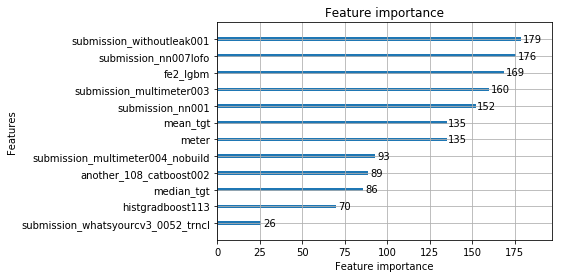

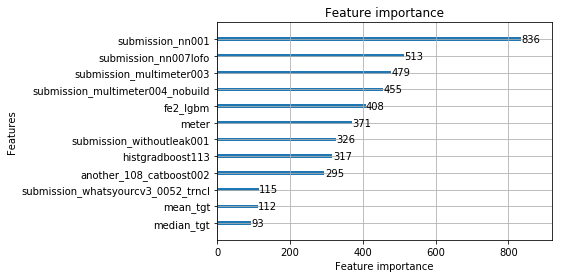

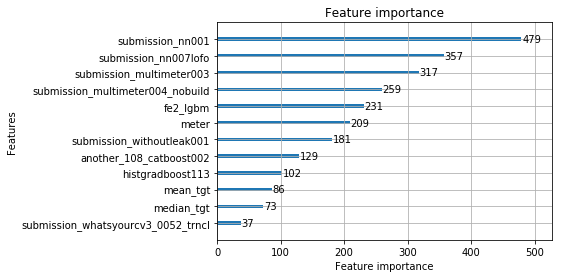

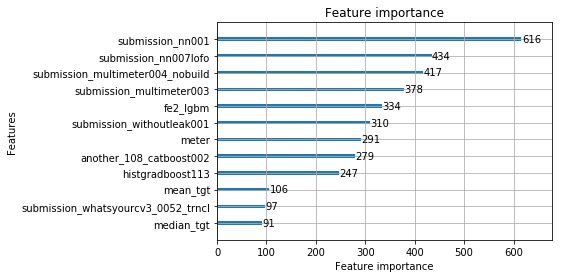

In [20]:
%matplotlib inline
for model in models:
    lgb.plot_importance(model)
#     plt.show()

# 3. final prediction using the ensemble model on the entire test set:

In [21]:
name_list

['submission_multimeter003',
 'submission_multimeter004_nobuild',
 'submission_withoutleak001',
 'submission_whatsyourcv3_0052_trncl',
 'submission_nn007lofo',
 'submission_nn001',
 'another_108_catboost002',
 'fe2_lgbm',
 'histgradboost113']

In [23]:
test = pd.read_feather('test_simple_cleanup.feather')
submission = pd.read_feather('leak012345_001.feather')
subm_full = pd.concat([test[['building_id','meter']], submission['meter_reading'], subm], axis=1).reset_index(drop=True)

In [24]:
subm_full['mean_tgt'] = subm_full[name_list].mean(axis=1)
subm_full['median_tgt'] = subm_full[name_list].median(axis=1)

In [25]:
subm_full[features].columns

Index(['meter', 'submission_multimeter003', 'submission_multimeter004_nobuild',
       'submission_withoutleak001', 'submission_whatsyourcv3_0052_trncl',
       'submission_nn007lofo', 'submission_nn001', 'another_108_catboost002',
       'fe2_lgbm', 'histgradboost113', 'mean_tgt', 'median_tgt'],
      dtype='object')

In [26]:
from tqdm import tqdm
i=0

res = np.zeros((subm_full.shape[0]),dtype=np.float32)
step_size = 500000
for j in tqdm(range(int(np.ceil(subm_full.shape[0]/step_size)))):
#     for_prediction = get_keras_data(test.iloc[i:i+step_size], numericals, categoricals)
    for_prediction = subm_full[features].iloc[i:i+step_size]
    res[i:min(i+step_size,subm_full.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, num_iteration=model.best_iteration) for model in models])/len(models))
    i+=step_size

100%|██████████| 84/84 [03:10<00:00,  2.04s/it]


In [27]:
# use of the leak for final submission:
submission = pd.read_feather('leak012345_001.feather')

In [28]:
submission['real'] = res

In [29]:
submission

,index,row_id,meter_reading,real
0,0,0,173.3703,154.582840
1,1,1,53.5127,70.915092
2,2,2,6.1430,8.802517
3,3,3,101.7015,209.091782
4,4,4,1141.2407,1107.388916
...,...,...,...,...
41697595,41697595,41697595,-9999.9900,6.285638
41697596,41697596,41697596,-9999.9900,4.357557
41697597,41697597,41697597,-9999.9900,4.075686
41697598,41697598,41697598,-9999.9900,160.161301


In [30]:
# concatenation of the leak and the ensembling prediction:
submission['meter_reading']  = np.where(submission.meter_reading==-9999.99, submission['real'], submission['meter_reading'])


In [31]:
submission[['row_id','meter_reading']].to_csv('submission_ensemble_3rd_place.csv.gz', index=False,  compression='gzip', float_format='%.4f', chunksize=25000)

In [32]:
!kaggle competitions submit -c ashrae-energy-prediction -f submission_ensemble_3rd_place.csv.gz -m "final ensemble 3rd place position"


100%|████████████████████████████████████████| 249M/249M [00:06<00:00, 38.8MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III